# The _fast & parallel_ Virtual Brain
## A fast implementation of The Virtual Brain brain network simulator
* written in C using a host of optimizations that make brain simulation reeeallllyy fast
* parallelized (multithreading) 
* containerized (can be conveniently run e.g. through Docker, Shifter or Singularity, without the need to install dependencies or set up environment)
* uses the Deco-Wang (aka "ReducedWongWang") neural mass model to simulate local brain region activity as described in Deco et al., 2014, Journal of Neuroscience or Schirner et al., 2018, eLife

### In this example we show how to start a containerized version of TVB on a supercomputer.
* First, we will upload our custom brain model to Collab Storage
* Then, we will copy the brain model into the virtual filesystem underlying the Python notebook container and from there onto the supercomputer
* Then, we will set up a job for the supercomputer batch system and submit it.
* Finally, we will download simulation results from the supercomputer.

### Note on the parallelization
In this version of TVB a simulation of a single parameter set is split up and distributed over several threads, that are then executed on multiple cores. For example, if a brain network model consists of 400 nodes and one uses 8 threads for simulation, each thread computes the activity of 50 nodes. Since the threads operate on shared memory, there is no additional overhead for distributing data between threads.

### To use this example notebook with your own data copy it to another Collab, adapt parameters below according to your setup, and then run all cells.

### Citation
If you use this code, please cite this publication where it was used first:

**Schirner, Michael, Anthony Randal McIntosh, Viktor Jirsa, Gustavo Deco, and Petra Ritter. "Inferring multi-scale neural mechanisms with brain network modelling." Elife 7 (2018): e28927.**

### Note: the fastTVB Docker Container is also freely available as a standalone and can be directly pulled from https://hub.docker.com/r/thevirtualbrain/fast_tvb and used on local (super)computers.


Michael Schirner, May 2020.  
michael.schirner@charite.de  
petra.ritter@charite.de

# 1. Prepare your brain model

Brain model data consists of a structural connectome (weights and distance files) and a parameter set (parameter file). Unlike the Python TVB version where brain model input data (i.e. the structural connectome) is stored as a Zip or hdf5 file, for this implementation a brain model simply consists of two ASCII text files and, additionally, one ASCII text files that contains the simulation parameters.

All three files must be stored in a folder with the name `input`. Additionally, we need a folder where outputs are stored called `output`.

__Naming conventions of weights and distance matrix files__

Connectome files must have the suffixes `"_SC_weights.txt"` or `"_SC_distances.txt"`

connection weights file: `<sub_id>_SC_weights.txt`

connection distances file: `<sub_id>_SC_distances.txt`

The subject identifier `<sub_id>` can be any arbitrary short (alphanumeric) string, e.g. `"sub002"`, and must be provided as a parameter to the batch file (which allows to have multiple different brain models stored in the same folder). 

Example:

```
sub002_SC_weights.txt
```

and

```
sub002_SC_distances.txt
```


__Formatting conventions of weights and distance matrix files__

ASCII text files that contain the connection weight and distance matrices as floating point numbers separated by white-spaces (columns) and line breaks/newline characters (rows). The unit of distances is _mm_ while connection weights are dimensionless and depend on the global coupling scaling factor parameter that is set in the parameter file.

Example (weights file):

```
0 0.012 0.0 0.119 0.0 1.1234 ...
0.012 0 0 0.0 1.34 ...
...
...
```

__Naming conventions of parameter file__

Arbitrary short string with the suffix `".txt"`. Must be provided as a parameter to the batch file (which allows to have multiple different parameter sets stored in the same folder). The file must have the suffix `".txt"` (actually, the TVB container is able to work with arbitrary parameter file names, but HBP Collab Storage prevents upload of files without suffix).

Example:

```
param_set_042.txt
```

__Formatting conventions of parameter file__

ASCII text file that contains the parameters as floating point or integer numbers separated by white spaces.

The sorting of the parameter file is:

```
nodes, G, J_NMDA, w_plus, Ji, sigma, time_steps, BOLD_TR, global_trans_v, rand_num_seed
```

**Important**: Correct formatting of floating point vs. integer numbers is mandatory. Integer parameters (like "number of nodes") must not be formatted as floating point numbers (don't format the integer "2" with a radix point like this "2.0")! For correct number format please refer to the table below.

Example:

```
379 1.000 0.150 1.400 1.000 0.0100 10000 720 12.5000 1403
```

__Parameter description__

For a detailed description of parameters see Deco et al. (2014) JNeuro or Schirner et al. (2018) eLife

Parameter | Description  | Number format
:---: | :---:  | :---: 
nodes | number of nodes in brain network model | Integer
G | global coupling scaling factor | Float
J_NMDA | strength of excitatory (NMDA) synpases | Float
w_plus | strength of local excitatory recurrence | Float
Ji | strength of local inhibitory (GABA) synapses | Float
sigma | noise strength | Float
time_steps | length of the simulation (ms) | Integer
BOLD_TR | TR of simulated fMRI BOLD signal (ms) | Integer
global_trans_v | transmission velocity of large-scale network (m/s) | Float
rand_num_seed | Seed to initialize random number generator | Integer

__Create input/output folders__

As final step, we create the folders `input` and `output` and copy the two connectome files and the parameter file into the folder `input`. The brain model is now ready to be used if you pull the Docker container into your (super)computer (e.g. `docker pull thevirtualbrain/fast_tvb`). If this is your goal, please refer to usage instructions on the Dockerhub page (https://hub.docker.com/r/thevirtualbrain/fast_tvb). In order to use it through EBRAINS Collabs, you can continue with the steps below.


## 2. Upload your brain model to the EBRAINS Collab

1. Navigate to the [Collabs](https://wiki.ebrains.eu/bin/view/Collabs/) page (https://wiki.ebrains.eu/bin/view/Collabs/)
2. Click on the "Create a Collab" button and fill out the form.
4. Click on "Drive" in the left sidebar menu. You might need to wait for a few seconds and refresh the page before it is visible.
5. Download this Ipython notebook to your local file system (e.g. by clicking on File->Save notebook as...) and upload it into your newly created Collab by using the "Upload" button on the "Drive" page.
6. Click on New to create a folder for your brain network model data (we will call it ```input``` here) and then upload your weights, distances and parameter files into the newly created folder (or drag & drop them into the new folder).
7. Make sure that the three files were successfully uploaded. They should now appear as the contents of the new folder.

In this example we uploaded the files
```
gavg_SC_distances.txt
gavg_SC_weights.txt
param_set.txt
```

Depending on whether you used a private or public repository the files will end up in either of the following folders in the filesystem of the EBRAINS Jupyter Hub at https://lab.ebrains.eu/

```
public_drive = 'drive/Shared with all'   

private_drive = 'drive/Shared with groups'
```

## 3. Upload brain model to supercomputer
 
Move over to EBRAINS Jupyter Hub to adapt this notebook according to your Collab file system.   

Build the path to the three files in your Collab like in the following code snippet.

In [1]:
# ADJUSTABLE PARAMETERS
################################
# paths for public and private drives
public_drive = 'drive/Shared with all'
private_drive = 'drive/Shared with groups'
which_drive = private_drive # is your Collab public or private?

subject_id = 'gavg' # prefix of weights and distances files
parameter_file = 'param_set.txt' # name of parameter set file

# Collab name
collab = 'TVB C -- High-speed parallel brain network models' # name of Collab

# data folder name
path = 'input' # the folder where you uploaded the three brain model files
################################

weights_file = subject_id + '_SC_weights.txt' # weights file must have this suffix
distances_file = subject_id + '_SC_distances.txt' # distances file must have this suffix

# get path of home folder
import os
home = os.getenv('HOME')



# full path
weights_path = os.path.join(home, which_drive, collab, path, weights_file)
distances_path = os.path.join(home, which_drive, collab, path, distances_file)
params_path = os.path.join(home, which_drive, collab, path, parameter_file)

print(weights_path)
print(distances_path)
print(params_path)

# Check whether the files are really there
print(os.path.exists(weights_path))
print(os.path.exists(distances_path))
print(os.path.exists(params_path))

/opt/app-root/src/drive/Shared with groups/TVB C -- High-speed parallel brain network models/input/gavg_SC_weights.txt
/opt/app-root/src/drive/Shared with groups/TVB C -- High-speed parallel brain network models/input/gavg_SC_distances.txt
/opt/app-root/src/drive/Shared with groups/TVB C -- High-speed parallel brain network models/input/param_set.txt
True
True
True


If we end up with "True" three times in a row, we have the correct paths.

Now it's time to upload our brain model to the supercomputer. Therefore, we create a PyUnicore client.

First, we update PyUnicore, if necessary. Then, we import it. Finally, we connect with PizDaint. To see which other supercomputers are there, and to learn their ID run the commented 
```
r.site_urls
```

To select a different supercomputer replace the supercomputer identifier string in
```
site_client = r.site('DAINT-CSCS')
```
with your preferred supercomputer.

In [12]:
# use the pyunicore library
!pip install pyunicore --upgrade
import pyunicore.client as unicore_client

tr = unicore_client.Transport(clb_oauth.get_token())
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)
site_client = r.site('DAINT-CSCS')

Requirement already up-to-date: pyunicore in /opt/app-root/lib/python3.6/site-packages (0.5.8)
You should consider upgrading via the '/opt/app-root/bin/python3 -m pip install --upgrade pip' command.


Next, we start an "empty" interactive job to get a workspace on PizDaint

In [13]:
job_description = {}
job = site_client.new_job(job_description)
storage = job.working_dir
#storage.properties

First, let's check the contents of the folder

In [14]:
storage.listdir()

{}

Good, it's empty. If it's not empty we can remove files or folders with `storage.rm(filename)` or `storage.rmdir(foldername)`. Run `help(storage)` for more information.

Now, let's create our `input` and `output` directories and then copy the three brain model files into `input`.

In [15]:
storage.mkdir('input')
storage.mkdir('output')
storage.listdir()

{'input/': PathDir: input/, 'output/': PathDir: output/}

Great, the two folders exist. While we are here, let's extract the path of our current working directory (mount point), we need it later when we generate the job script.

In [18]:
mp = (storage.properties['mountPoint']).encode('ascii').decode('utf-8')
mp

'/scratch/snx3000/unicore/FILESPACE/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4/'

Now, let's copy the three brain model files into input. With the last two lines we check whether the folder `input` contains our three files. 

In [17]:
storage.upload(input_name=weights_path, destination = "input/" + weights_file)
storage.upload(input_name=distances_path, destination = "input/" + distances_file)
storage.upload(input_name=params_path, destination = "input/" + parameter_file)

r=storage.stat("input")
r.properties

{'owner': 'bp000225',
 'size': 4096,
 '_links': {'next': {'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4-uspace/files?offset=3&num=3'},
  'self': {'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4-uspace/files?offset=0&num=3'},
  'parentStorage': {'description': 'Parent Storage',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4-uspace'}},
 'permissions': 'rwx------',
 'lastAccessed': '2020-05-05T13:09:07+0200',
 'isDirectory': True,
 'content': {'/input/gavg_SC_distances.txt': {'owner': 'bp000225',
   'size': 1672575,
   'permissions': 'rw-------',
   'lastAccessed': '2020-05-05T13:09:07+0200',
   'isDirectory': False,
   'group': 'bp0'},
  '/input/gavg_SC_weights.txt': {'owner': 'bp000225',
   'size': 1580051,
   'permissions': 'rw-------',
   'lastAccessed': '2020-05-05T13:09:07+0200',
   'isDirectory': False,
 

We see that the folder "input" has three children -- our three uploaded files. Great, the entire brain model is now copied to the supercomputer. What remains to be done is generating a batch script for SLURM (the job manager; installed on many supercomputers), copying the script into our current working directory and submitting the job to the queue.


## 6. Create SLURM job script for supercomputer
### Specify input data set, output folder and simulation parameters
HBP supercomputers use SLURM to manage job queues. Below we create a SLURM submission script that loads required modules and then posts a simulation job to the queue.

### Configure the following parameters: 
* paths of input/output folders
* data set ID
* path of parameter file
* number of parallel threads
  * optimum depends on the supercomputer architecture and the size of the brain model 

Note: instead of directly starting a job on the batch system, we use PyUnicore to submit a job on the login node, which in turn submits a job for the batch system. This gives us a greater flexibility to configure our job, we don't have to learn so much PyUnicore (although it's great!) and are falisafe if PyUnicore misses bindings for certain job managers. Note that before we run the container, we make sure that the image is up to date, or, if non-existent, gets pulled for the first time.

Supercomputers typically don't have Docker installed due to security reasons, but more secure alternatives like Sarus. Usage is usually very similar, but permissions are more restricted.

Below is a brief outline of the Sarus run command. For a great in-depth tutorial check out the help pages of the Swiss CSCS supercomputing site: https://user.cscs.ch/tools/containers/

```
sarus run <container_name> 
```
is the standard way of running a container.
Here, we additionally use the `mount` command to directly mount the `input` and the `output` folders into the container's filesystem's top-level directories `/input` and `/output`. 

Example:
```
srun sarus run --mount=type=bind,source=/path/to/output,target=/output --mount=type=bind,source=/path/to/input,target=/input thevirtualbrain/fast_tvb /start_simulation.sh <Arguments>
```


**Important**: the container assumes that the external folders mounted to `/input` and `/output` in its virtual file system contain the input data, respectively, are the place where output data shall be stored. If there is no rw access to these folders container execution will fail!

Output will be stored into the `output` folder following the naming schema
```
<sub_id>_<paramset_file>_fMRI.txt
```

The entrypoint script in the root folder of the container is called `start_simulation.sh` and it needs three arguments: the name of the parameter file, the subject ID and the number of threads.

The command format of the entry-point script is

Usage: 
```
/start_simulation.sh <paramset_file> <sub_id> <#threads>
```

Example: 
```
/start_simulation.sh param_set42.txt sub0014 8
```

For an in-depth discussion of Sarus (Shifter, Singularity) usage, check out this documentation:
https://user.cscs.ch/tools/containers/

In [35]:
# ADJUSTABLE PARAMETERS
################################################
wall_time = "00:10:00" # ADJUST wall time of job
cpu_per_task = "36" # ADJUST according to supercomputer architecture
num_threads = "4" # ADJUST according to size of the model
################################################

# FIXED PARAMETERS
################################################
job_script = "job_script" # name of the job script file
input_folder = mp + "input" 
output_folder = mp + "output" 
################################################


with open(job_script, "w") as f:
    f.write("#!/bin/bash -l\n")  
    f.write("#SBATCH --time=" + wall_time + "\n")
    f.write("#SBATCH --output=slurm-" + job_script + ".out\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")    
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=" + cpu_per_task + "\n")
    f.write("#SBATCH --partition=normal\n")
    f.write("#SBATCH --constraint=mc\n")
    f.write("#SBATCH --hint=nomultithread\n") # disable hyperthreading such that all cores become available for multithreading
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("module load /apps/daint/UES/easybuild/modulefiles/daint-mc\n")
    f.write("module load /apps/daint/system/modulefiles/sarus/1.1.0\n\n")
    f.write("srun sarus pull thevirtualbrain/fast_tvb\n")
    f.write("srun sarus run --mount=type=bind,source=" + output_folder + \
            ",target=/output --mount=type=bind,source=" + input_folder + \
            ",target=/input thevirtualbrain/fast_tvb /start_simulation.sh " + \
            parameter_file + " " + subject_id + " " + num_threads + "\n")

Let's check the generated script

In [36]:
!cat job_script

#!/bin/bash -l
#SBATCH --time=00:10:00
#SBATCH --output=slurm-job_script.out
#SBATCH --nodes=1
#SBATCH --ntasks-per-core=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=36
#SBATCH --partition=normal
#SBATCH --constraint=mc
#SBATCH --hint=nomultithread
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
module load /apps/daint/UES/easybuild/modulefiles/daint-mc
module load /apps/daint/system/modulefiles/sarus/1.1.0

srun sarus pull thevirtualbrain/fast_tvb
srun sarus run --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4/output,target=/output --mount=type=bind,source=/scratch/snx3000/unicore/FILESPACE/84abe3c4-1ed5-4bb9-b3cc-d8352a4d8fb4/input,target=/input thevirtualbrain/fast_tvb /start_simulation.sh param_set.txt gavg 4


Looking good!

## 7. Upload SLURM script to supercomputer

Here we use the same upload function as used previously for the brain model data followed by a quick check whether the file arrived.

In [37]:
storage.upload(input_name=job_script, destination = job_script)
storage.listdir()

{'input/': PathDir: input/,
 'job_script': PathFile: job_script,
 'output/': PathDir: output/}

Nice!

## 8. Launching the simulation on the supercomputer

The big moment has come, we will now finally launch the simulation. We do this by executing the the SLURM command `sbatch`, which will evaluate our batch file and generate a job out of it that is added to the queue.
After we executed the job, we extract the working directory of this job (which is different from the other working directory that we created above, where the folders `input` and `output` are located).

In [38]:
rr=site_client.execute("sbatch " + mp + "job_script")
rr.working_dir.properties['mountPoint']

'/scratch/snx3000/unicore/FILESPACE/e9ceff19-64ad-46cd-bebb-fe62e1adbd91/'

Let's peak into the working directory of the job we just started

In [39]:
rr.working_dir.listdir()

{'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'UNICORE_SCRIPT_PID': PathFile: UNICORE_SCRIPT_PID,
 'stderr': PathFile: stderr,
 'stdout': PathFile: stdout}

Now that we made sure that the simulation is running smoothly, we finished quite an amount of work. Congratulations so far! I think you earned yourself a short break. Go outside for a few minutes and get some fresh air and light!

I'll wait.

...

...

...

Are you back? Great! There's not much left to do now. What we gonna do is: check whether the simulation runs or ran smoothly, copy the result into our virtual file system of the notebook, plot the result and finally copy it into storage so you can download it.

First, let's peek into the SLURM output file -- we defined its name above when we generated the batch script. We used the job script name to define it.

Most important are the last 19 lines of the output file. Important is the line `MT-TVBii finished. Execution took X s for Y nodes. Goodbye!`, which indicates that the simulation finished successfully. The table below shows you when the job started, when it finished and how long it took. If these lines are missing the job is either still running or something went wrong.

In [42]:
job_out = rr.working_dir.stat("slurm-" + job_script + ".out")
job_out.raw().readlines()[-30:]

[b'> extracting     : "/scratch/snx3000/bp000225/.sarus/cache/sha256:0571ba2e30b3a699d35acaabc06a2691111f6808243de8af95d41b292acfc660.tar"\n',
 b'> extracting     : "/scratch/snx3000/bp000225/.sarus/cache/sha256:25fac3f3dc88d5f2fe23b018a7bce5989e1c95e725ed419b296a4d799255c88b.tar"\n',
 b'> make squashfs image: "/scratch/snx3000/bp000225/.sarus/images/index.docker.io/thevirtualbrain/fast_tvb/latest.squashfs"\n',
 b'\n',
 b'Warning: Specified number of nodes (379) is not a multiple of vectorization degree (4). Will add some fake nodes... \n',
 b'\n',
 b'thread 0: start: 0 end: 96 size: 96\n',
 b'thread 1: start: 96 end: 192 size: 96\n',
 b'thread 2: start: 192 end: 288 size: 96\n',
 b'thread 3: start: 288 end: 380 size: 92\n',
 b'0.0 % \r0.0 % \r0.0 % \r0.0 % \r0.0 % \r0.0 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.1 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.2 % \r0.3 % \r0.3 % \r0.3 % \r0.3 % \r0.3 % \r0.3 % \r0.3 % 

## 9. Collecting the results

In our example everything went smoothly, so let's collect the results and plot them.

In [43]:
result_filename = subject_id + "_" + parameter_file + "_fMRI.txt"

storage.stat("output/" + result_filename).download(result_filename)

import numpy as np

fMRI = np.genfromtxt(result_filename)

Text(0, 0.5, 'fMRI Amplitude (1)')

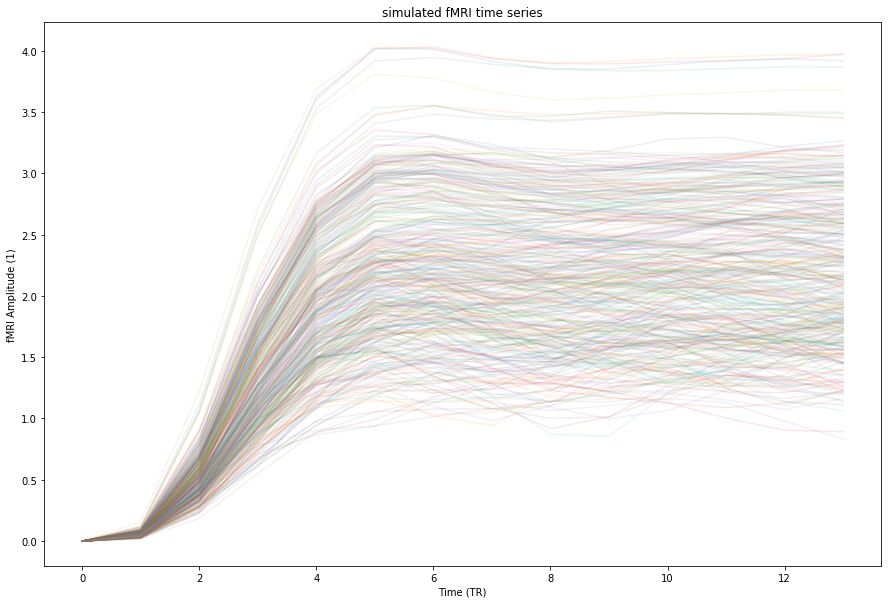

In [45]:
%matplotlib inline
from matplotlib.pyplot import *
figure(figsize=(15, 10))
plt = plot(fMRI.T, alpha=0.1)
title("simulated fMRI time series")
xlabel('Time (TR)')
ylabel('fMRI Amplitude (1)')

Beautiful!

We're done! 

Your simulation results should await you under the filename ```result_filename``` in the folder of this notebook. Right-click and "Download" and you can download the data to your local computer.


**If you would like to use fast_TVB on your local (super)computer without the intermediary Collab, just pull it from Dockerhub into your local machine**

https://hub.docker.com/r/thevirtualbrain/fast_tvb

```
docker pull thevirtualbrain/fast_tvb
```


Feedback may be addressed to:

michael.schirner@charite.de

or

petra.ritter@charite.de


Here's the end. Enjoy your day!


